In [3]:
# Essential and common packages
import os
import glob

# Read and visualize the raster data
import rasterio
from rasterio.plot import show

# Plots and bars
import matplotlib.pyplot as plt
import seaborn as sns

# Computation library
import numpy as np

# Tensorflow for building the resnet50 model
import tensorflow.python.keras as k
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import random_uniform, glorot_uniform
from tensorflow.keras.models import Model

# Sklearn for confusion matrix
import itertools
#from sklearn.metrics import confusion_matrix, plot_confusion_matrix

# For visualization of plots without plt.show()
%matplotlib inline

import scipy as sp

In [4]:
dataset_url = r'E:\SIH\EuroSAT\2750'
batch_size = 32
img_height = 64
img_width = 64
validation_split=0.2
rescale=1.0/255

In [5]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=validation_split, rescale=rescale)
dataset = tf.keras.preprocessing.image_dataset_from_directory(dataset_url, image_size=(img_height, img_width), batch_size=batch_size)

Found 27000 files belonging to 10 classes.


In [6]:
train_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_url,
                                           shuffle=True,
                                           target_size=(img_height, img_width),
                                           subset="training",
                                           class_mode='categorical')

Found 21600 images belonging to 10 classes.


In [7]:
test_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_url,
                                           shuffle=True,
                                           target_size=(img_height, img_width),
                                           subset="validation",
                                           class_mode='categorical')

Found 5400 images belonging to 10 classes.


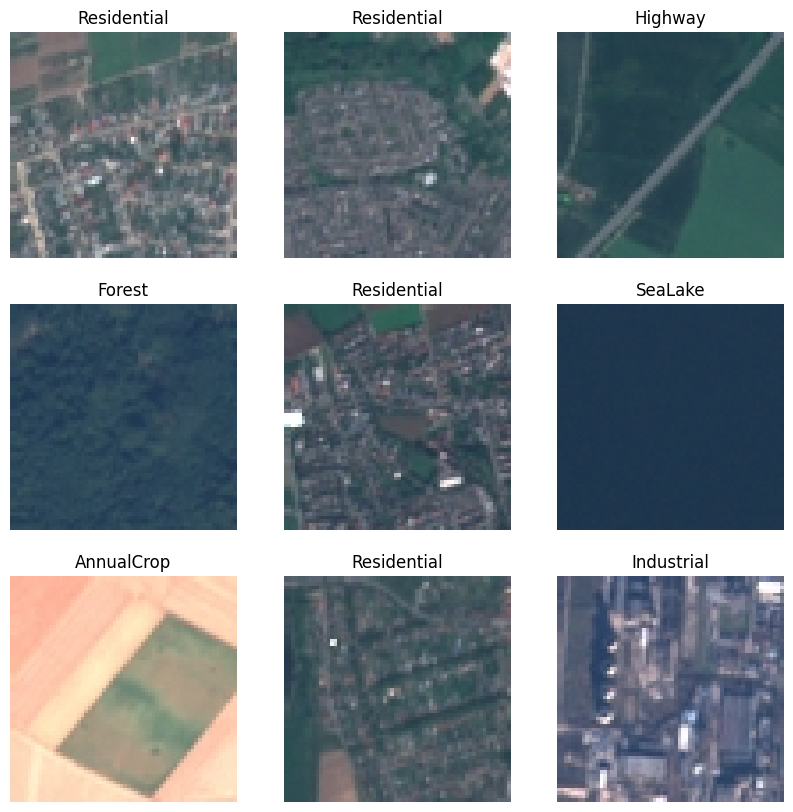

In [8]:
class_names = dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [10]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value.
    X_shortcut = X
    cache = []
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut, X])
    X = X = Activation('relu')(X, training = training)

    return X

In [11]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    
    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    
    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s, s), padding = 'valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training = training)

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [12]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    
   # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size = (2, 2), name = 'avg_pool')(X)
    

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [13]:
import scipy
model = ResNet50(input_shape=(64,64,3), classes=10)

In [14]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
# please increase the epoch for higher accuracy (epochs=100)
history = model.fit(train_dataset, validation_data=test_dataset, epochs=20, batch_size=32)

Epoch 1/20
675/675 [==============================] - 1036s 2s/step - loss: 1.5966 - accuracy: 0.5209 - val_loss: 1.1901 - val_accuracy: 0.5919
Epoch 2/20
675/675 [==============================] - 930s 1s/step - loss: 0.9874 - accuracy: 0.6632 - val_loss: 1.1885 - val_accuracy: 0.5909
Epoch 3/20
675/675 [==============================] - 6076s 9s/step - loss: 0.8362 - accuracy: 0.7262 - val_loss: 0.9003 - val_accuracy: 0.6900
Epoch 4/20
675/675 [==============================] - 887s 1s/step - loss: 0.7957 - accuracy: 0.7361 - val_loss: 1.0016 - val_accuracy: 0.6900
Epoch 5/20
675/675 [==============================] - 881s 1s/step - loss: 0.7793 - accuracy: 0.7606 - val_loss: 0.9472 - val_accuracy: 0.7037
Epoch 6/20
675/675 [==============================] - 889s 1s/step - loss: 0.7319 - accuracy: 0.7642 - val_loss: 1.4731 - val_accuracy: 0.6531
Epoch 7/20
675/675 [==============================] - 969s 1s/step - loss: 0.6964 - accuracy: 0.7747 - val_loss: 0.6668 - val_accuracy: 0.77

In [16]:
model.save('lulc_20_epoch')

INFO:tensorflow:Assets written to: lulc_20_epoch\assets


INFO:tensorflow:Assets written to: lulc_20_epoch\assets


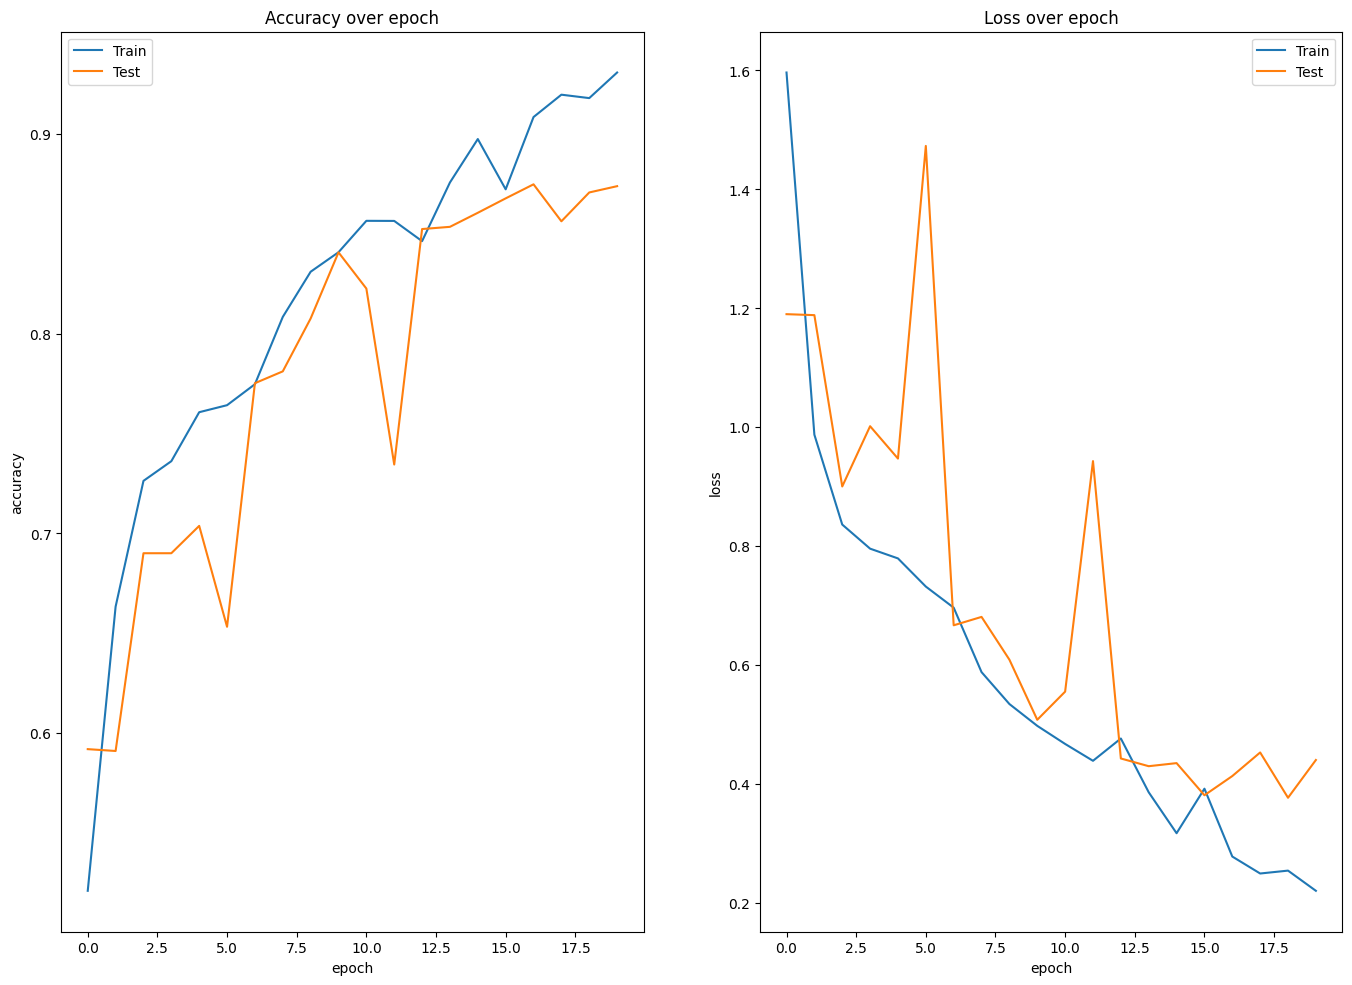

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16.53, 11.69))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.set_title('Accuracy over epoch')
ax1.legend(['Train', 'Test'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.set_title('Loss over epoch')
ax2.legend(['Train', 'Test'], loc="upper right")

In [18]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for i, (image_batch, label_batch) in enumerate(test_dataset):   # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch)
    # compute predictions
    preds = model.predict(image_batch)
    # append predicted labels
    y_pred.append(np.argmax(preds, axis =  1))
    if i==300:
        break

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
correct_labels = np.argmax(correct_labels, axis=1)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 0s 254ms/step


In [35]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Function to load and preprocess the image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (64, 64))
    img_array = np.expand_dims(img, axis=0)
    img_array = img_array / 255.0  # Normalize pixel values
    return img_array

# Function to make predictions
def predict_land_use(image_path, model, class_names):
    # Preprocess the image
    img_array = preprocess_image(image_path)

    # Make predictions
    predictions = model.predict(img_array)

    # Get the predicted class index
    predicted_class_index = np.argmax(predictions)

    # Get the predicted class name
    predicted_class_name = class_names[predicted_class_index]

    return predicted_class_name

# Example usage:
# Replace 'path_to_your_image.jpg' with the path to your satellite image file
image_path = 'E:/SIH/predict/bhopal01.jpg'

# Load the trained model
loaded_model = load_model('lulc_20_epoch')

# Define the class names used during training
class_names = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']  # Replace with your actual class names

# Use the predict_land_use function to get the predicted land use category
predicted_category = predict_land_use(image_path, loaded_model, class_names)

print(f'The predicted land use category is: {predicted_category}')


1/1 [==============================] - 2s 2s/step
The predicted land use category is: Highway


In [36]:
image_path = 'E:/SIH/predict/bhopal02.jpg'

# Load the trained model
loaded_model = load_model('lulc_20_epoch')

# Define the class names used during training
class_names = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']  # Replace with your actual class names

# Use the predict_land_use function to get the predicted land use category
predicted_category = predict_land_use(image_path, loaded_model, class_names)

print(f'The predicted land use category is: {predicted_category}')

1/1 [==============================] - 1s 1s/step
The predicted land use category is: Industrial
